In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torchvision import datasets
import torchvision.transforms as transforms
from tensorboardX import SummaryWriter

```
uv pip install torch torchvision --index-url https://download.pytorch.org/whl/cu126
```

In [3]:
import torch

torch.cuda.is_available()

True

In [4]:
# train 전처리해주면 test도 같은 전처리 해줘야함

data_transform = transforms.Compose(
    [
        transforms.ToTensor(),              # tensor 변환
        transforms.Resize(32),              # 이미지 크기변경
        transforms.Normalize((0.5), (1.0))  # 정규화 (평균, 표준편차)
    ]
)

train_data = datasets.MNIST(root="./", train=True, download=True, transform=data_transform)
test_data = datasets.MNIST(root="./", train=False, download=True, transform=data_transform)

In [5]:
train_data.data.shape
# 안바뀜 -> dataLoader를 통해 가져와야 바뀜

torch.Size([60000, 28, 28])

In [6]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32)

In [7]:
next(iter(train_loader))[0]
# 정규화되었기 때문에 값이 바뀌었다

tensor([[[[-0.5000, -0.5000, -0.5000,  ..., -0.5000, -0.5000, -0.5000],
          [-0.5000, -0.5000, -0.5000,  ..., -0.5000, -0.5000, -0.5000],
          [-0.5000, -0.5000, -0.5000,  ..., -0.5000, -0.5000, -0.5000],
          ...,
          [-0.5000, -0.5000, -0.5000,  ..., -0.5000, -0.5000, -0.5000],
          [-0.5000, -0.5000, -0.5000,  ..., -0.5000, -0.5000, -0.5000],
          [-0.5000, -0.5000, -0.5000,  ..., -0.5000, -0.5000, -0.5000]]],


        [[[-0.5000, -0.5000, -0.5000,  ..., -0.5000, -0.5000, -0.5000],
          [-0.5000, -0.5000, -0.5000,  ..., -0.5000, -0.5000, -0.5000],
          [-0.5000, -0.5000, -0.5000,  ..., -0.5000, -0.5000, -0.5000],
          ...,
          [-0.5000, -0.5000, -0.5000,  ..., -0.5000, -0.5000, -0.5000],
          [-0.5000, -0.5000, -0.5000,  ..., -0.5000, -0.5000, -0.5000],
          [-0.5000, -0.5000, -0.5000,  ..., -0.5000, -0.5000, -0.5000]]],


        [[[-0.5000, -0.5000, -0.5000,  ..., -0.5000, -0.5000, -0.5000],
          [-0.5000, -0.500

In [8]:
data, label = next(iter(train_loader))
print(data.shape)
# [60000, 28, 28] -> [32, 1, 32, 32] 바뀜

torch.Size([32, 1, 32, 32])


- Lenet5 : http://vision.stanford.edu/cs598_spring07/papers/Lecun98.pdf

In [9]:
# 이미지의 사이즈에 따라 fc1 의 in_features, fc2의 out_features 만 바꿔서 사용하면 된다
# 보통은 논문 그대로 쓰고, full connection 만 바꿔줌

class Lenet(nn.Module) :     # class 이름이 곧 모델명(Lenet)
    def __init__(self) :
        super(Lenet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1)
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1)
        self.fc1 = nn.Linear(in_features=120, out_features=84)
        self.fc2 = nn.Linear(in_features=84, out_features=10)

    def forward(self, x) :
        x = self.conv1(x)
        x = F.tanh(x)               # 6, 28, 28 (활성화함수)
        x = F.max_pool2d(x, 2, 2)   # 6, 14, 14 (2X2 max pooling)

        x = self.conv2(x)
        x = F.tanh(x)
        x = F.max_pool2d(x, 2, 2)

        x = self.conv3(x)
        x = F.tanh(x)
        x = x.view(-1, 120)

        x = self.fc1(x)
        x = F.tanh(x)

        x = self.fc2(x)
        x = F.tanh(x)

        return x

In [10]:
model = Lenet()
model

Lenet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=120, out_features=84, bias=True)
  (fc2): Linear(in_features=84, out_features=10, bias=True)
)

```
uv add torch-summary
```

In [11]:
from torchsummary import summary

In [19]:
summary(model, input_size=(1, 32, 32), verbose=2)

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            156
├─Conv2d: 1-2                            2,416
├─Conv2d: 1-3                            48,120
├─Linear: 1-4                            10,164
├─Linear: 1-5                            850
Total params: 61,706
Trainable params: 61,706
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            156
├─Conv2d: 1-2                            2,416
├─Conv2d: 1-3                            48,120
├─Linear: 1-4                            10,164
├─Linear: 1-5                            850
Total params: 61,706
Trainable params: 61,706
Non-trainable params: 0

In [13]:
# 학습시키기
lr = 1e-3
optim = Adam(model.parameters(), lr=lr)
epochs = 10
criterion = nn.CrossEntropyLoss()

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

writer = SummaryWriter()
step = 0

for epoch in range(epochs) :
    for data, label in train_loader :
        optim.zero_grad()
        pred = model(data.to(device))  # [32, 1, 32, 32]
        loss = criterion(pred, label.to(device))
        writer.add_scalar("Loss/train", loss, step)
        step += 1

        loss.backward()
        optim.step()

    print(f"{epoch+1} loss ::: {loss.item()}")

1 loss ::: 0.806262731552124
2 loss ::: 0.8068898916244507
3 loss ::: 0.797527551651001
4 loss ::: 0.8375831842422485
5 loss ::: 0.7971524596214294
6 loss ::: 0.8716562986373901
7 loss ::: 0.7989715337753296
8 loss ::: 0.8001868724822998
9 loss ::: 0.7987685203552246
10 loss ::: 0.8456776142120361


In [ ]:
# 1. 모델 평가 코드작성 (정확도)
# 2. 이미지파일(data/4.jpg)을 불러와서 모델에 넣어 결과 받기
# 2-1. 이미지 불러오기
# 2-2. 이미지를 학습할때와 같이 전처리 해준다
# 2-3. 모델에 넣고 추론
# 결과 : [-, -, -, -, @, -, -, ...] -> 4 값이 제일 높게 나와야 정답
# 모델에 이미지 넣을때 주의할 점 : shape 똑같게 해야함

In [22]:
# 평가
model.eval()

with torch.no_grad() :
    total_corr = 0
    for images, labels in test_loader :
        # images = images.view(-1, 120).to(device)
        
        labels = labels.to(device)

        preds = model(images.to(device))

        _, pred = torch.max(preds.data, 1)
        total_corr = total_corr + (pred == labels).sum().item()

print(f"정확도 : {total_corr/len(test_data.targets)}")

정확도 : 0.9883


In [24]:
# 이미지 파일 불러오기
from PIL import Image

img = Image.open("data/4.jpg").convert("L")


In [26]:
# 이미지 전처리
img_transform = transforms.Compose(
    [
        transforms.ToTensor(),              # tensor 변환
        transforms.Resize(32),              # 이미지 크기변경
        transforms.Normalize((0.5), (1.0))  # 정규화 (평균, 표준편차)
    ]
)
input_tensor = img_transform(img)

In [29]:
# input_tensor의 사이즈 확인
input_tensor.size()

# model : [32, 1, 32, 32]
# unsqueeze 사용
input_tensor = input_tensor.unsqueeze(0)

In [31]:
# 모델 불러오기 & 추론
model.eval()
with torch.no_grad():
    output = model(input_tensor.to(device))

In [32]:
# 예측결과 해석
predict = output.argmax(dim=1).item()
predict

4

---

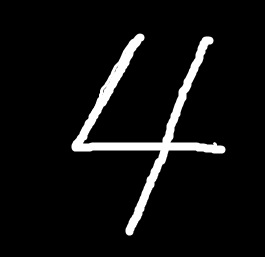

In [33]:
# 이미지 불러오기
from PIL import Image

img = Image.open("data/4.jpg")
img

In [ ]:
import numpy as np

img_array = np.array(img)
img_array.shape
# 우리가 알던 shape 과 다르다 (-> 흑백이아니고 RGB / 차원수도 다름)

(257, 265, 3)

In [35]:
# 이미지 전처리
infer_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Grayscale(),
    transforms.Resize(32),
    transforms.Normalize((0.5), (1.0))
])

infer_img = infer_transform(img)
infer_img.size()

torch.Size([1, 32, 32])

In [36]:
model(infer_img.to(device))

tensor([[-1.0000, -1.0000, -1.0000, -1.0000,  1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000]], device='cuda:0', grad_fn=<TanhBackward0>)

In [37]:
# 추론하는걸 함수로 만드는 습관을 들이자!